# 2021-03-24

Trying to do a three-way quantitation of Rpb1 foci, 120-mer GFP particles, and single MS2-labeled mRNP particles. 

First, import and run functions.

In [3]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
from skimage.filters.thresholding import threshold_otsu

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [312]:
from fitting import fitgaussian3d, gaussian3d
from imagep import get_object_centroid, clamp

def fit_objects_from_mask(stack, mask, fitwindow_rad_xy=10, fitwindow_rad_z=2):  
    def get_fitwindow(data, peak, xy_rad, z_rad):
        """Retrieve section of image stack corresponding to given
        window around a point and the coordinate adjustments necessary
        to convert window coordinates to coordinates in the original image"""
        
        # Set the start points for windows and "adjust" them if they get 
        # to negative numbers.
        zmin = peak[0] - z_rad
        xmin = peak[1] - xy_rad
        ymin = peak[2] - xy_rad
        # Initialize adjustments to values that are correct if no edge problems 
        # are encountered.
        z_adj = -z_rad
        x_adj = -xy_rad
        y_adj = -xy_rad
        # Update mins and adjustments if windows start at negative coordinates.
        if (zmin < 0):
            zmin = 0
            z_adj = -peak[0]
        if (xmin < 0):
            xmin = 0
            x_adj = -peak[1]
        if (ymin < 0):
            ymin = 0
            y_adj = -peak[2]

        # Get end points, constained by max coordinate in data.
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)

        return (data[zmin:(zmax+1), xmin:(xmax+1), ymin:(ymax+1)], z_adj, x_adj, y_adj)
    
    def get_centroids(labelmask):
        centroids = []
        for id_ in np.unique(labelmask):
            centroids.append(get_object_centroid(labelmask, id_))
        return centroids
    
    def fit_frame(substack, submask):
        labelmask = ndi.label(submask)[0]
        peaks = get_centroids(labelmask)
        count = 0
        
        # Fit 3D gaussian in window surrounding each local maximum.
        fitparams = np.ndarray((0,7))
        for peak in peaks:
            count += 1
            if ((count % 100) == 0):
                print(count, end=' ')
            fitwindow, z_adj, x_adj, y_adj = get_fitwindow(substack, peak, fitwindow_rad_xy, 
                fitwindow_rad_z)
            opt = fitgaussian3d(fitwindow)
            if opt.success:
                peak_fitparams = opt.x
                # Move center coordinates to match center of gaussian fit, ensure they're within image. 
                # If they're outside the image, coordinate is assigned as the edge of the image.
                peak_fitparams[0] = int(round(clamp((peak[0] + peak_fitparams[0] + z_adj), 0, substack.shape[-3]-1)))
                peak_fitparams[1] = int(round(clamp((peak[1] + peak_fitparams[1] + x_adj), 0, substack.shape[-2]-1)))
                peak_fitparams[2] = int(round(clamp((peak[2] + peak_fitparams[2] + y_adj), 0, substack.shape[-1]-1)))
                fitparams = np.vstack((fitparams, peak_fitparams))
            # If fit fails, add dummy entry for spot.
            else:
                fitparams = np.vstack((fitparams, np.array([z_adj,x_adj,y_adj,0,np.inf,np.inf,np.inf])))
        return fitparams
    
    fit_data = []
    for t in range(0, stack.shape[0]):
        print(t)
        fit_data.append(fit_frame(stack[t], mask[t]))
    
    return fit_data

In [5]:
def fg_bg(x, inner_ij=5, outter_ij=7, inner_z=1, outter_z=3, bg_subtract=True):
    z=3
    # ij:
    midpoint = int(x.shape[-1] / 2)
    inner_rad_ij = int(inner_ij / 2)
    outter_rad_ij = int(outter_ij / 2)
    inner_start_ij = midpoint - inner_rad_ij
    inner_end_ij = midpoint + inner_rad_ij + 1
    outter_start_ij = midpoint - outter_rad_ij
    outter_end_ij = midpoint + outter_rad_ij + 1
    # z:
    midpoint_z = int(x.shape[-3] / 2)
    inner_rad_z = int(inner_z / 2)
    outter_rad_z = int(outter_z / 2)
    inner_start_z = midpoint_z - inner_rad_z
    inner_end_z = midpoint_z + inner_rad_z + 1
    outter_start_z = midpoint_z - outter_rad_z
    outter_end_z = midpoint_z + outter_rad_z + 1
    
    means = []
    for box in x:
        inner_box = box[inner_start_z:inner_end_z, inner_start_ij:inner_end_ij, inner_start_ij:inner_end_ij]
        if (bg_subtract):
            outter_box = box[outter_start_z:outter_end_z, outter_start_ij:outter_end_ij, outter_start_ij:outter_end_ij] 
            outter_mean = (np.sum(outter_box) - np.sum(inner_box)) / (outter_box.size - inner_box.size)
            inner_mean = np.mean(inner_box)
            bgsub_mean = inner_mean - outter_mean
            means.append(bgsub_mean)
        else:
            means.append(np.mean(inner_box))
    return means  

### Processing 120-mer movies

In [38]:
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210318-120merGFP-488-3pct-em1-01.czi'
stack = read_czi(czi_filename, swapaxes=True)
imp.viewer(stack)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [43]:
stack4d = stack[0,:1,10:]
stack5d = np.expand_dims(stack4d, axis=0)

In [44]:
stack4d.shape

(1, 4, 379, 1069)

In [45]:
min_distances = (4, 10, 10)
fitwindow_rad_xy = 10
fitwindow_rad_z = 2
sigma_small = 1
spotchannel=0

fits = imp.fit_ms2(stack4d, min_distances=min_distances, fitwindow_rad_xy=fitwindow_rad_xy, sigma_small=sigma_small)

In [46]:
imp.quickview_ms2(stack5d, fits, MAX=True)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [51]:
peakiness = 4
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
imp.quickview_ms2(stack5d, fits_filtered, halfwidth_z=0, MAX=True)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [133]:
spot_data = imp.connect_ms2_fits_focuscorrect(fits_filtered, [0], [0], np.zeros_like(stack4d))
spots = imp.spot_movies(stack5d, spot_data, fill=0, view=False)
spots = np.squeeze(spots)

In [138]:
spot_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/spotboxes_20210322-120merGFP-488-3pct-em1-01.pkl'
save_pickle(spots, spot_filename)

## Processing Rpb1 minor foci

In [552]:
stack = read_czi('/Volumes/Stadler100/2021-03-31/20210331-rpbGFP-sisAMS2-488-3pct-em4-02.czi', swapaxes=True)
imp.viewer(stack)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [553]:
stack4d = stack[0,:1]
stack5d = np.expand_dims(stack4d, axis=0)

In [554]:
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = imp.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [555]:
t = 8000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [556]:
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)

0
100 200 300 400 500 600 700 800 

In [557]:
peakiness = 9
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
imp.quickview_ms2(stack5d, fits_filtered, halfwidth_z=0, MAX=False, shadows=False)

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/imagep.py:2212: RuntimeWarning: divide by zero encountered in log
  spot_peakiness = np.log(peak_heights / xy_width_means)


interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [559]:
spots_byz = []
for i in range(0, stack4d.shape[-3]-1):
    zslice_bool = fits_filtered[0][:,0] == i
    fits_zslice = [fits_filtered[0][zslice_bool]]
    spot_data = imp.connect_ms2_fits_focuscorrect(fits_zslice, [0], [0], np.zeros_like(stack4d))
    spots = imp.spot_movies(stack5d, spot_data, fill=0, len_ij=31,view=False)
    spots = np.squeeze(spots)
    spots_byz.append(spots)

In [562]:
save_pickle(spots_byz.copy(),'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210331_rpb1_spots_byz_4_02.pkl')

spots_byz_rpb1_331_4_02 = spots_byz.copy()

In [289]:
viewer(spots, 6)

interactive(children=(Dropdown(description='Color', index=3, options=('Reds', 'cividis', 'plasma', 'Greens', '…

## Processing MS2 spots

In [293]:
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210322-MCPGFP-Hbms2-488-3pct-em1-03.czi'
stack = read_czi(czi_filename, swapaxes=False)
imp.viewer(stack)

interactive(children=(Dropdown(description='Color', index=3, options=('Reds', 'cividis', 'plasma', 'Greens', '…

In [294]:
stack4d = stack[:1]
stack5d = np.expand_dims(stack4d, axis=0)

In [295]:
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = imp.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [300]:
# Make quick nuclear mask.
his_channel=1
mcp_channel=0
hisstack = stack[his_channel].copy()
hisstack = ndi.gaussian_filter(hisstack, sigma=3)
t = threshold_otsu(hisstack)
mask = np.where(hisstack > t, 1, 0)
nucmask = ndi.morphology.binary_dilation(mask, np.ones((1,5,5)))
#nucmask = ndi.morphology.binary_erosion(mask, np.ones((1,2,2)))
viewer(nucmask)

interactive(children=(Dropdown(description='Color', index=3, options=('Reds', 'cividis', 'plasma', 'Greens', '…

In [301]:
dog = np.where(nucmask, dog, 0)

In [305]:
t = 12000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

interactive(children=(Dropdown(description='Color', index=1, options=('Reds', 'cividis', 'plasma', 'Greens', '…

In [308]:
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)

0
(15, 166, 594)
(0, 51, 227)
(0, 57, 219)
(0, 57, 875)
(0, 59, 666)
(0, 82, 379)
(0, 98, 120)
(0, 100, 580)
(0, 117, 52)
(0, 124, 614)
(0, 129, 388)
(0, 134, 303)
(0, 133, 456)
(0, 135, 730)
(0, 136, 514)
(0, 137, 726)
(0, 138, 747)
(0, 141, 33)
(0, 143, 292)
(0, 145, 288)
(0, 146, 296)
(0, 152, 487)
(0, 153, 209)
(0, 154, 205)
(0, 156, 477)
(0, 156, 488)
(0, 157, 62)
(0, 168, 349)
(0, 176, 713)
(0, 197, 16)
(0, 207, 40)
(0, 213, 7)
(0, 209, 12)
(0, 213, 94)
(0, 214, 122)
(0, 215, 92)
(0, 216, 107)
(0, 223, 5)
(0, 222, 345)
(0, 226, 134)
(0, 228, 39)
(0, 229, 976)
(0, 230, 135)
(0, 232, 0)
(0, 235, 131)
(0, 249, 253)
(0, 252, 983)
(0, 252, 255)
(0, 252, 643)
(0, 257, 479)
(0, 268, 221)
(0, 273, 599)
(0, 272, 747)
(0, 273, 223)
(0, 276, 364)
(0, 284, 555)
(0, 287, 556)
(0, 289, 250)
(0, 289, 243)
(0, 290, 561)
(0, 297, 100)
(0, 298, 611)
(0, 304, 187)
(0, 306, 800)
(0, 313, 596)
(0, 314, 691)
(0, 318, 689)
(0, 330, 84)
(0, 331, 69)
(1, 23, 639)
(2, 30, 620)
(1, 47, 45)
(1, 48, 235)
(1,

(21, 223, 363)
(20, 260, 228)
(20, 271, 769)
(20, 309, 592)
(20, 308, 596)
(21, 53, 1058)
(21, 55, 211)
(21, 59, 204)
(21, 67, 45)
(21, 92, 141)
(21, 147, 999)
(21, 151, 1002)
(21, 203, 852)
(21, 204, 848)
(21, 211, 853)
(21, 215, 359)
(21, 219, 369)
(21, 250, 112)
(21, 251, 115)
(21, 312, 597)
(22, 55, 1056)
(22, 58, 55)
(22, 98, 144)
(22, 152, 999)
(22, 162, 478)
(22, 206, 852)
(22, 207, 846)
(22, 212, 847)
(22, 214, 851)
(22, 217, 365)
(22, 220, 366)
(22, 263, 38)
(22, 312, 594)
(23, 52, 1057)
(23, 183, 732)
(23, 208, 848)
(23, 213, 855)
(23, 312, 110)
(24, 63, 89)
(24, 94, 141)
(24, 99, 138)
(24, 217, 25)
(24, 310, 594)
(24, 318, 112)
(25, 49, 1055)
(25, 52, 1056)
(25, 98, 142)
(27, 316, 593)
(26, 1, 962)
(26, 104, 145)
(27, 94, 144)
(27, 100, 147)
(30, 103, 121)


In [310]:
imp.quickview_ms2(stack5d, fits, MAX=False, shadows=False, halfwidth_z=0)

interactive(children=(Dropdown(description='Color', index=1, options=('Reds', 'cividis', 'plasma', 'Greens', '…

In [312]:
peakiness = 7
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
imp.quickview_ms2(stack5d, fits_filtered, halfwidth_z=0, MAX=False, shadows=False)

interactive(children=(Dropdown(description='Color', index=1, options=('Reds', 'cividis', 'plasma', 'Greens', '…

## Z-slice woes

From the 120-mer stacks, it's clear that there's a significant decrease in intensity with increasing Z slice (deeper into the embryo). This could be from scattering or from bleaching. Some of the stacks included two time points, and it is clear from these that bleaching is a minor contribution. I can think of two ways of dealing with this. The first is two rely on the data averaging out: use inputs from multiple embryos with identical scan depths for each input, hope that the effect evens out. The second is explicit correction. This is the better and more rigorous approach.

The strategy here would be to use the 120mers to calibrate signal decrease as a function of depth into the embryo, by measuring the position of the coverslip. From these data we can derive a correction function, and for all subsequent datasets, we would need to measure and record the position of the coverslip. It will still be important to have inputs from multiple embryos, and I think measuring the laser power will also be critical (to avoid the difficulty of having to do all experiments on the same day). 

Going to see if I can do anything with these data before while I'm waiting for the chance to collect new data.

In [255]:
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210322-120merGFP-488-3pct-em3-01.czi'
stack = read_czi(czi_filename, swapaxes=False)
viewer(stack)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [258]:
stack4d = stack[:1]
#stack4d = np.expand_dims(stack, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

In [259]:
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = imp.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [260]:
t = 10000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [261]:
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
viewer(mask)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [262]:
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
imp.quickview_ms2(stack5d, fits, MAX=True, shadows=False, halfwidth_z=0)

0


interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [263]:
peakiness = 8
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
imp.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [264]:
spots_byz = []
for i in range(0, stack.shape[-3]-1):
    zslice_bool = fits_filtered[0][:,0] == i
    fits_zslice = [fits_filtered[0][zslice_bool]]
    spot_data = imp.connect_ms2_fits_focuscorrect(fits_zslice, [0], [0], np.zeros_like(stack4d))
    spots = imp.spot_movies(stack5d, spot_data, fill=0, len_ij=31,view=False)
    spots = np.squeeze(spots)
    spots_byz.append(spots)

In [265]:
spots_byz_3_01 = spots_byz.copy()

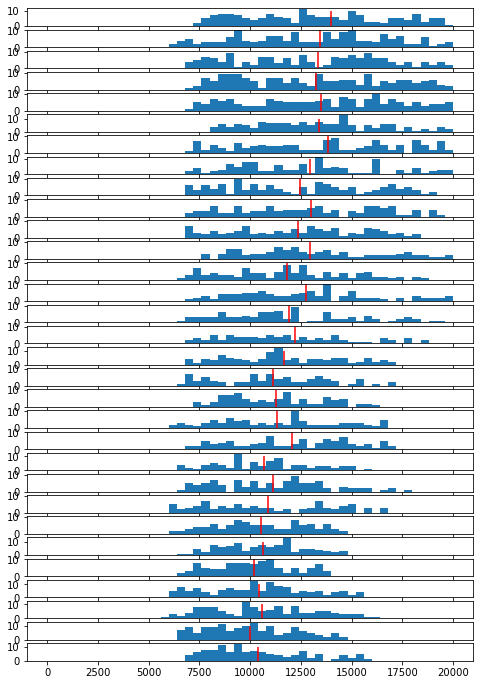

In [270]:
# em3-01
spots_byz = spots_byz_3_01
n = len(spots_byz)
plt.subplots(n, 1, figsize=(8,12))
for i in range(0, n):
    plt.subplot(n,1,i+1)
    inner_ij=5
    outter_ij=9
    inner_z=1
    outter_z=1
    bg_subtract = True
    
    vals = fg_bg(spots_byz[i], inner_ij=inner_ij, outter_ij=outter_ij, inner_z=inner_z, 
                 outter_z=outter_z, bg_subtract=bg_subtract)
    vals = np.array(vals)
    low_cut, high_cut = np.percentile(vals, [10,90])
    #print(vals <= low_cut)
    vals = vals[(vals >= low_cut) & (vals <= high_cut)]
    plt.hist(vals, range=(0,20000), bins=50);
    plt.vlines(np.mean(vals), 0,10, color='red')

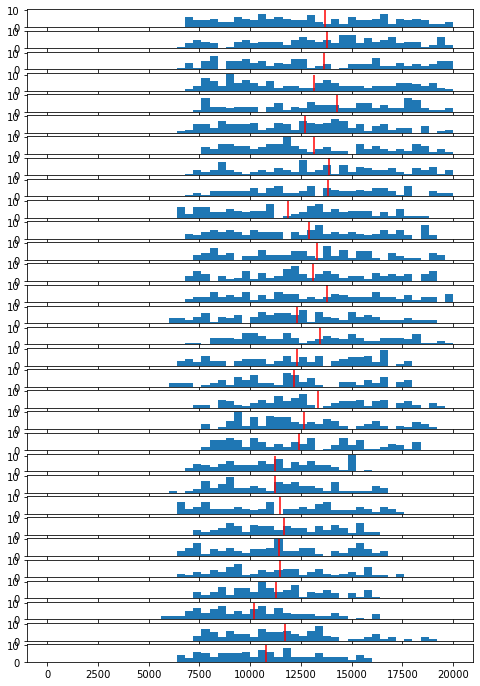

In [253]:
# em1-02
spots_byz = spots_byz_1_02
n = len(spots_byz)
plt.subplots(n, 1, figsize=(8,12))
for i in range(0, n):
    plt.subplot(n,1,i+1)
    inner_ij=5
    outter_ij=9
    inner_z=1
    outter_z=1
    bg_subtract = True
    
    vals = fg_bg(spots_byz[i], inner_ij=inner_ij, outter_ij=outter_ij, inner_z=inner_z, 
                 outter_z=outter_z, bg_subtract=bg_subtract)
    vals = np.array(vals)
    low_cut, high_cut = np.percentile(vals, [10,90])
    #print(vals <= low_cut)
    vals = vals[(vals >= low_cut) & (vals <= high_cut)]
    plt.hist(vals, range=(0,20000), bins=50);
    plt.vlines(np.mean(vals), 0,10, color='red')

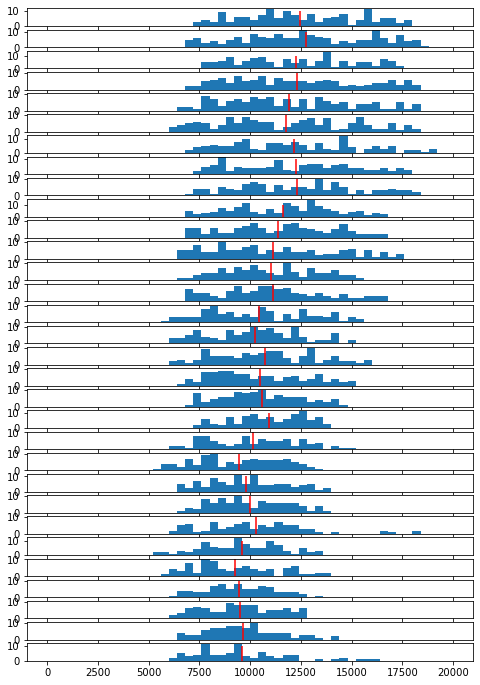

In [243]:
# em2-02
n = len(spots_byz)
plt.subplots(n, 1, figsize=(8,12))
for i in range(0, n):
    plt.subplot(n,1,i+1)
    inner_ij=5
    outter_ij=9
    inner_z=1
    outter_z=1
    bg_subtract = True
    
    vals = fg_bg(spots_byz[i], inner_ij=inner_ij, outter_ij=outter_ij, inner_z=inner_z, 
                 outter_z=outter_z, bg_subtract=bg_subtract)
    vals = np.array(vals)
    low_cut, high_cut = np.percentile(vals, [10,90])
    #print(vals <= low_cut)
    vals = vals[(vals >= low_cut) & (vals <= high_cut)]
    plt.hist(vals, range=(0,20000), bins=50);
    plt.vlines(np.mean(vals), 0,10, color='red')

OK, let's suppose we had depth information, so each slice in each stack could be assigned a distance from the embryo surface. We could have a vector of depths matching the Z slices in our spots_byz object...

I think to avoid the effects of differences in spot number, I should use averages. So for each dataset, produce matching vectors of the average for each slice and the position relative to the embryo surface. Then concatenate them all together, fit some function to them (look at them to see if linear is appropriate).

In [277]:
stepsize = 0.150
start = 1.2
steps = 31

x = (np.arange(0, steps) * stepsize) + start

In [283]:
spots_byz = spots_byz_3_01
def fg_bg_byz(spots_byz, inner_ij=5, outter_ij=9, inner_z=1, outter_z=1, bg_subtract=True):
    y = []
    n = len(spots_byz)
    for i in range(0, n):
        vals = fg_bg(spots_byz[i], inner_ij=inner_ij, outter_ij=outter_ij, inner_z=inner_z, 
                     outter_z=outter_z, bg_subtract=bg_subtract)
        vals = np.array(vals)
        low_cut, high_cut = np.percentile(vals, [10,90])
        vals = vals[(vals >= low_cut) & (vals <= high_cut)]
        y.append(np.mean(vals))
    return y

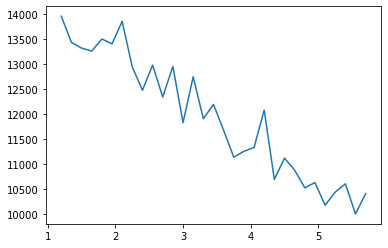

In [284]:
plt.plot(x,y)

### Imaging experiments to account for embryo depth effects

For taking data:

- Focus on 120-mers
- Measure laser power
- Record position of coverslip/embryo surface
- Record position of Z-stack (or figure out how to get it from metadata)
- Take two frames for each position
- Get many positions across many embryos
- From this, calibrate correction for fluorescence vs. embryo depth

I took a bunch of movies with these conditions on 3/30. For each dataset, I recorded the position of the embryo surface and the position of the start of the Z stack. I ran through the following routine for datasets from 6 datasets from 5 embryos to segment spots, determine spot intensities, and get the "spot movies" (boxes of the image centered around detected spots, separated out by Z slices.

In [425]:
del stack, stack3d, stack4d, stack5d, fits, dog, fits_filtered, mask, spots_byz

In [426]:
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210330-120merGFP-488-3pct-em6-01.czi'
stack = read_czi(czi_filename, swapaxes=False)
viewer(stack)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [427]:
stack4d = stack[:1]
#stack4d = np.expand_dims(stack, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

In [428]:
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = imp.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [429]:
t = 10000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [430]:
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
viewer(mask)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [431]:
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
#imp.quickview_ms2(stack5d, fits, MAX=True, shadows=False, halfwidth_z=0)

0
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 

In [432]:
peakiness = 8
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
imp.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [433]:
spots_byz = []
for i in range(0, stack.shape[-3]-1):
    zslice_bool = fits_filtered[0][:,0] == i
    fits_zslice = [fits_filtered[0][zslice_bool]]
    spot_data = imp.connect_ms2_fits_focuscorrect(fits_zslice, [0], [0], np.zeros_like(stack4d))
    spots = imp.spot_movies(stack5d, spot_data, fill=0, len_ij=31,view=False)
    spots = np.squeeze(spots)
    spots_byz.append(spots)

In [434]:
spots_byz_6_01 = spots_byz.copy()

In [453]:
save_pickle(spots_byz_1_02,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210330_spots_byz_1_02.pkl')
save_pickle(spots_byz_1_03,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210330_spots_byz_1_03.pkl')
save_pickle(spots_byz_3_01,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210330_spots_byz_3_01.pkl')
save_pickle(spots_byz_4_01,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210330_spots_byz_4_01.pkl')
save_pickle(spots_byz_5_01,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210330_spots_byz_5_01.pkl')
save_pickle(spots_byz_6_01,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210330_spots_byz_6_01.pkl')


With these made, I then use this fg_bg_byz function which uses the foreground/background function I previously wrote to get a normalized intensity for each spot in a dataset. I then take the mean value for all the spots in each z plane, giving me a vector, y, of the mean normalized intensity of spots in each z slice in a dataset.

In [374]:
def fg_bg_byz(spots_byz, inner_ij=5, outter_ij=9, inner_z=1, outter_z=1, bg_subtract=True):
    y = []
    n = len(spots_byz)
    for i in range(0, n):
        vals = fg_bg(spots_byz[i], inner_ij=inner_ij, outter_ij=outter_ij, inner_z=inner_z, 
                     outter_z=outter_z, bg_subtract=bg_subtract)
        vals = np.array(vals)
        low_cut, high_cut = np.percentile(vals, [10,90])
        vals = vals[(vals >= low_cut) & (vals <= high_cut)]
        y.append(np.mean(vals))
    return y

I run the above function on each dataset and also generate a matching vector with teh embryo depth of each slice, based on the recorded positions. These vectors are concatenated for all datasets.

In [437]:
datasets = [spots_byz_1_02, spots_byz_1_03, spots_byz_3_01, spots_byz_4_01, spots_byz_5_01, spots_byz_6_01]
surface = [-116.3,-117,-118.9,-123.7,-83.99,-141.9]
start = [-106.98,-105.75,-107.2,-119.26,-80.52,-133.8]
interval = 0.240

x = []
y = []
for i in range(0, len(datasets)):
    y1 = fg_bg_byz(datasets[i], bg_subtract=True)
    y = y + y1
    x1 = (np.arange(0, len(y1)) * interval) + start[i] - surface[i]
    x = x + list(x1)
    print(len(x))

31
62
93
124
155
186


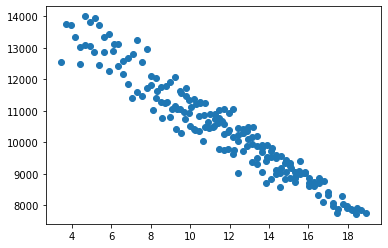

In [455]:
plt.scatter(x,y)

This is obviously a nice linear relationship. I do a standard linear fit:

In [439]:
from scipy.optimize import curve_fit

def func(x, m, b):
    return (x * m) + b

curve_fit(func, x, y)

(array([ -393.95404182, 15025.25369212]),
 array([[  66.37809982, -773.08360182],
        [-773.08360182, 9964.49668287]]))

Text(0.5, 1.0, 'Spot intensity vs. embryo depth')

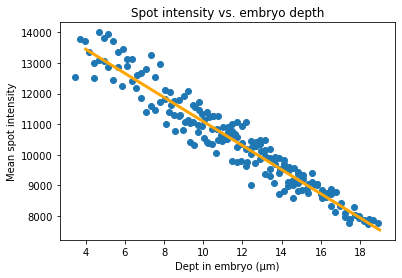

In [451]:
# Make a nice plot of the data and the fit.
f_x = np.arange(4,20)
f_y = (f_x * -393.95) + 15025.25

plt.scatter(x,y)
plt.plot(f_x,f_y, color="orange", linewidth=3, alpha=1)
plt.xlabel('Dept in embryo (µm)')
plt.ylabel('Mean spot intensity')
plt.title('Spot intensity vs. embryo depth')


Wow, this is tremendous. Spot intensity is clearly a linear function of embryo depth, and this is a LARGE effect that must be accounted for. 

It turns out that there was an issue with the imaging--I needed to have the filters set to block mCherry/RFP. Ugh. I retook a bunch of 120-mer movies with these conditions. Running through the above pipeline again:

In [534]:
del stack, stack3d, stack4d, stack5d, fits, dog, fits_filtered, mask, spots_byz

In [535]:
czi_filename = '/Volumes/Stadler100/2021-03-31/20210331-120mers-3pct-em6-02.czi'
stack = read_czi(czi_filename, swapaxes=True)
viewer(stack)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [536]:
stack4d = stack[0,:1,:]
#stack4d = np.expand_dims(stack, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

In [538]:
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = imp.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [539]:
t = 10000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [540]:
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
viewer(mask)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [541]:
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
#imp.quickview_ms2(stack5d, fits, MAX=True, shadows=False, halfwidth_z=0)

0
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 

In [542]:
peakiness = 8
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack)
imp.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)

interactive(children=(Dropdown(description='Color', index=6, options=('Reds', 'magma', 'inferno', 'gray', 'Gat…

In [543]:
spots_byz = []
for i in range(0, stack4d.shape[-3]-1):
    zslice_bool = fits_filtered[0][:,0] == i
    fits_zslice = [fits_filtered[0][zslice_bool]]
    spot_data = imp.connect_ms2_fits_focuscorrect(fits_zslice, [0], [0], np.zeros_like(stack4d))
    spots = imp.spot_movies(stack5d, spot_data, fill=0, len_ij=31,view=False)
    spots = np.squeeze(spots)
    spots_byz.append(spots)


In [544]:
save_pickle(spots_byz.copy(),'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210331_spots_byz_6_02.pkl')

spots_byz_331_6_02 = spots_byz.copy()

In [545]:
datasets = [spots_byz_331_4_01, spots_byz_331_4_02, spots_byz_331_2_02, spots_byz_331_5_01, spots_byz_331_5_02, spots_byz_331_6_01, spots_byz_331_6_02]
surface = [1565.78, 1564.08, 1615.68, 1564.51, 1564.33, 1568.97, 1567.8]
start = [1573.99, 1569.91, 1620.8, 1573.48, 1568.38, 1571.79, 1574.71]
interval = 0.240

x = []
y = []
for i in range(0, len(datasets)):
    y1 = fg_bg_byz(datasets[i], bg_subtract=True)
    y = y + y1
    x1 = (np.arange(0, len(y1)) * interval) + start[i] - surface[i]
    x = x + list(x1)
    print(len(x))

31
62
81
112
143
174
205


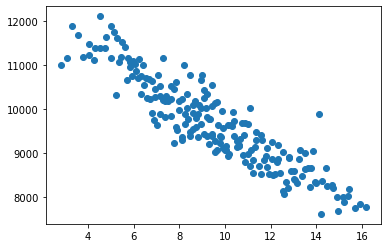

In [546]:
plt.scatter(x,y)

In [547]:
from scipy.optimize import curve_fit

def func(x, m, b):
    return (x * m) + b

curve_fit(func, x, y)

(array([ -305.43251494, 12582.51083525]),
 array([[  89.94895016, -854.91431044],
        [-854.91431044, 8947.34990782]]))

Text(0.5, 1.0, 'Spot intensity vs. embryo depth')

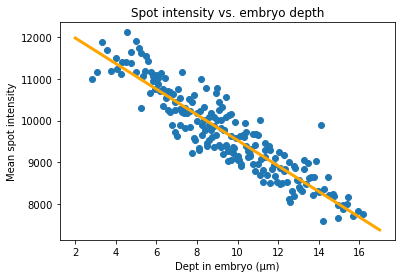

In [550]:
# Make a nice plot of the data and the fit.
f_x = np.arange(2,18)
f_y = (f_x * -305.43) + 12582.51

plt.scatter(x,y)
plt.plot(f_x,f_y, color="orange", linewidth=3, alpha=1)
plt.xlabel('Dept in embryo (µm)')
plt.ylabel('Mean spot intensity')
plt.title('Spot intensity vs. embryo depth')

In [564]:
datasets = [spots_byz_rpb1_331_4_02]
surface = [1292.75]
start = [1296.98]
interval = 0.240

x_rpb = []
y_rpb = []
for i in range(0, len(datasets)):
    y1 = fg_bg_byz(datasets[i], bg_subtract=True)
    y_rpb = y_rpb + y1
    x1 = (np.arange(0, len(y1)) * interval) + start[i] - surface[i]
    x_rpb = x_rpb + list(x1)
    print(len(x_rpb))

31


/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


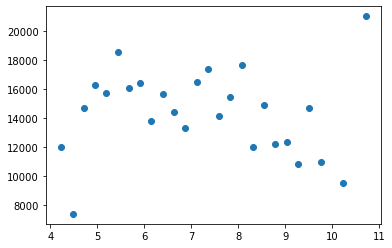

In [565]:
plt.scatter(x_rpb, y_rpb)